In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
%run 'functions.py'

In [3]:
tariffs = pd.read_parquet('../data/tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

lows_2014 = lows + np.timedelta64(365, 'D')
normals_2014 = normals + np.timedelta64(365, 'D')
highs_2014 = highs + np.timedelta64(365, 'D')

In [4]:
total_acorn = pd.read_parquet('../data/total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [5]:
total_usage_2013 = pd.read_parquet('../data/total_usage_2013.gzip')
total_usage_2014 = pd.read_parquet('../data/total_usage_2014.gzip')

In [6]:
slice_2013 = total_usage_2013.loc[(total_usage_2013['date_time'].dt.normalize() <= '2013-02-27')]
slice_2014 = total_usage_2014.loc[(total_usage_2014['date_time'].dt.normalize() <= '2014-02-27')]

In [7]:
slice_2013_t, slice_2013_c = split_t_c(slice_2013)
slice_2014_t, slice_2014_c = split_t_c(slice_2014)

In [8]:
slice_2013_t_af = get_dem(slice_2013_t, affluent)
slice_2013_c_af = get_dem(slice_2013_c, affluent)
slice_2013_t_com = get_dem(slice_2013_t, comfortable)
slice_2013_c_com = get_dem(slice_2013_c, comfortable)
slice_2013_t_ad = get_dem(slice_2013_t, adversity)
slice_2013_c_ad = get_dem(slice_2013_c, adversity)

In [9]:
slice_2014_t_af = get_dem(slice_2014_t, affluent)
slice_2014_c_af = get_dem(slice_2014_c, affluent)
slice_2014_t_com = get_dem(slice_2014_t, comfortable)
slice_2014_c_com = get_dem(slice_2014_c, comfortable)
slice_2014_t_ad = get_dem(slice_2014_t, adversity)
slice_2014_c_ad = get_dem(slice_2014_c, adversity)

- a2014 X = b2014
- a2013 X = ~b2013

In [167]:
a_2013, b_2013, a_2014, b_2014 = get_alpha_beta(slice_2013_t, slice_2013_c, slice_2014_t, slice_2014_c)

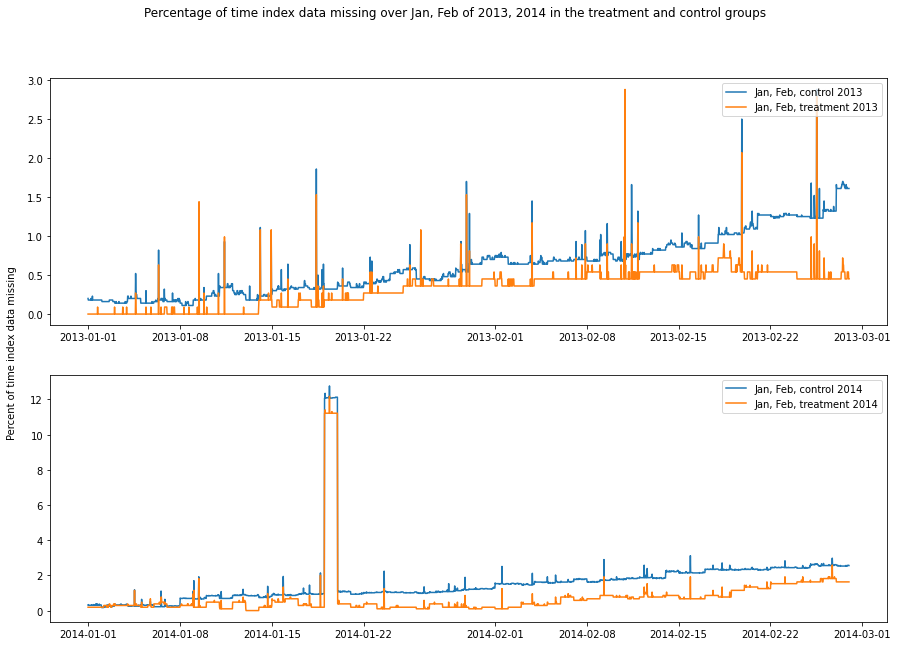

In [211]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Percentage of time index data missing over Jan, Feb of 2013, 2014 in the treatment and control groups')

ax[0].plot(get_percentage_time_missing(a_2013), label='Jan, Feb, control 2013')
ax[0].plot(get_percentage_time_missing(b_2013), label='Jan, Feb, treatment 2013')
ax[0].legend(loc=1)

ax[1].plot(get_percentage_time_missing(a_2014), label='Jan, Feb, control 2014')
ax[1].plot(get_percentage_time_missing(b_2014), label='Jan, Feb, treatment 2014')
ax[1].legend(loc=1)

fig.text(0.09, 0.5, 'Percent of time index data missing', ha='center', va='center', rotation='vertical')
plt.savefig('../figs/jf_1314_percent_data_missing.png');

In [24]:
a_2013_dropped, b_2013_dropped, a_2014_dropped, b_2014_dropped = get_matrices_dropped(slice_2013_t, 
                                                                                      slice_2013_c, 
                                                                                      slice_2014_t, 
                                                                                      slice_2014_c,
                                                                                      0)

before anything (2784, 4406) (2784, 1111) (2784, 4065) (2784, 1043)
after cleaning (2784, 3319) (2784, 838) (2784, 2599) (2784, 676)
after house intersection (2784, 2000) (2784, 520) (2784, 2000) (2784, 520)


In [17]:
a_2013_imputed, b_2013_imputed, a_2014_imputed, b_2014_imputed = get_matrices_imputed(slice_2013_t, 
                                                                                      slice_2013_c, 
                                                                                      slice_2014_t, 
                                                                                      slice_2014_c)

before anything (2784, 4406) (2784, 1111) (2784, 4065) (2784, 1043)
after imputation (2784, 4406) (2784, 1111) (2784, 4065) (2784, 1043)
after house intersection (2784, 4060) (2784, 1037) (2784, 4060) (2784, 1037)


In [118]:
# b_2013_dropped_est = find_counterfactual(a_2014_dropped, b_2014_dropped, a_2013_dropped, b_2013_dropped)
b_2013_imputed_est = find_counterfactual(a_2014_imputed, b_2014_imputed, a_2013_imputed, b_2013_imputed)

In [75]:
# a_2014_imputed_inv = np.linalg.pinv(a_2014_imputed)
# X = a_2014_imputed_inv @ b_2014_imputed.to_numpy()
# b_2013_imputed_est_ = a_2013_imputed.to_numpy() @ X

# b_2013_imputed_est = pd.DataFrame(b_2013_imputed_est_, columns=b_2013_imputed.columns, index=b_2013_imputed_est.index)

In [102]:
a_2014_dropped_inv = np.linalg.pinv(a_2014_dropped)
X = a_2014_dropped_inv @ b_2014_dropped.to_numpy()
b_2013_dropped_est_ = a_2013_dropped.to_numpy() @ X

b_2013_dropped_est = pd.DataFrame(b_2013_dropped_est_, columns=b_2013_dropped.columns, index=b_2013_dropped_est.index)

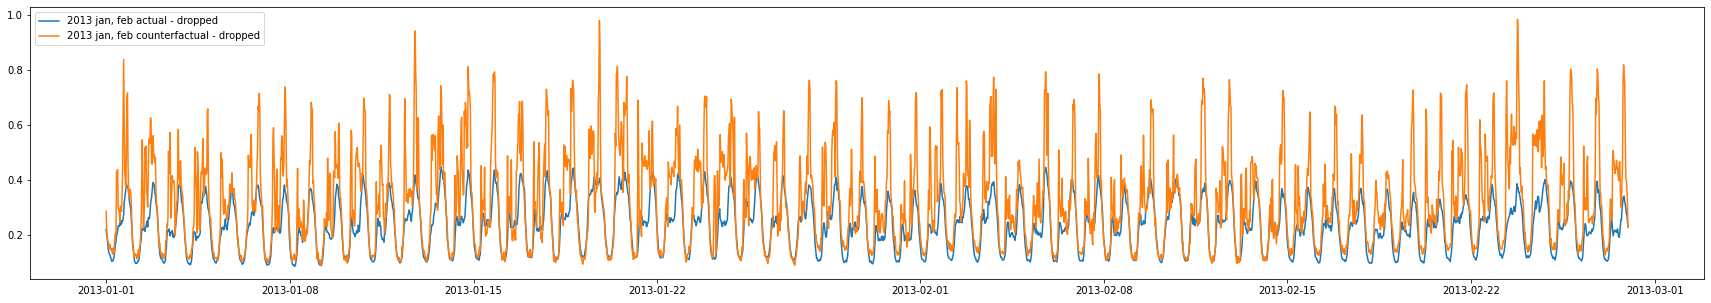

In [152]:
plt.figure(figsize=(30, 5))
n=5000
plt.plot(b_2013_dropped.mean(axis=1)[:n], label='2013 jan, feb actual - dropped')
plt.plot(b_2013_dropped_est.mean(axis=1)[:n], label='2013 jan, feb counterfactual - dropped')
plt.legend()
plt.show()

In [129]:
ME_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])

In [216]:
# b2 = b_2013_imputed
# b2_est = b_2013_imputed_est

b2 = b_2013_dropped
b2_est = b_2013_dropped_est

In [217]:
ME_consumption.loc['Affluent', 'Low'], MPE_consumption.loc['Affluent', 'Low'] = get_subset(b2, b2_est, lows, affluent)

ME_consumption.loc['Affluent', 'Normal'], MPE_consumption.loc['Affluent', 'Normal'] = get_subset(b2, b2_est, normals, affluent)

ME_consumption.loc['Affluent', 'High'], MPE_consumption.loc['Affluent', 'High'] = get_subset(b2, b2_est, highs, affluent)

ME_consumption.loc['Affluent', 'Overall'], MPE_consumption.loc['Affluent', 'Overall'] = get_subset(b2, b2_est, b2.index, affluent)

ME_consumption.loc['Comfortable', 'Low'], MPE_consumption.loc['Comfortable', 'Low'] = get_subset(b2, b2_est, lows, comfortable)

ME_consumption.loc['Comfortable', 'Normal'], MPE_consumption.loc['Comfortable', 'Normal'] = get_subset(b2, b2_est, normals, comfortable)

ME_consumption.loc['Comfortable', 'High'], MPE_consumption.loc['Comfortable', 'High'] = get_subset(b2, b2_est, highs, comfortable)

ME_consumption.loc['Comfortable', 'Overall'], MPE_consumption.loc['Comfortable', 'Overall'] = get_subset(b2, b2_est, b2.index, comfortable)

ME_consumption.loc['Adversity', 'Low'], MPE_consumption.loc['Adversity', 'Low'] = get_subset(b2, b2_est, lows, adversity)

ME_consumption.loc['Adversity', 'Normal'], MPE_consumption.loc['Adversity', 'Normal'] = get_subset(b2, b2_est, normals, adversity)

ME_consumption.loc['Adversity', 'High'], MPE_consumption.loc['Adversity', 'High'] = get_subset(b2, b2_est, highs, adversity)

ME_consumption.loc['Adversity', 'Overall'], MPE_consumption.loc['Adversity', 'Overall'] = get_subset(b2, b2_est, b2.index, adversity)

ME_consumption.loc['Overall', 'Low'], MPE_consumption.loc['Overall', 'Low'] = get_subset(b2, b2_est, lows, b2.columns)

ME_consumption.loc['Overall', 'Normal'], MPE_consumption.loc['Overall', 'Normal'] = get_subset(b2, b2_est, normals, b2.columns)

ME_consumption.loc['Overall', 'High'], MPE_consumption.loc['Overall', 'High'] = get_subset(b2, b2_est, highs, b2.columns)

ME_consumption.loc['Overall', 'Overall'], MPE_consumption.loc['Overall', 'Overall'] = get_subset(b2, b2_est, b2.index, b2.columns)

In [218]:
ME_consumption = ME_consumption.astype(float)
MPE_consumption = MPE_consumption.astype(float)

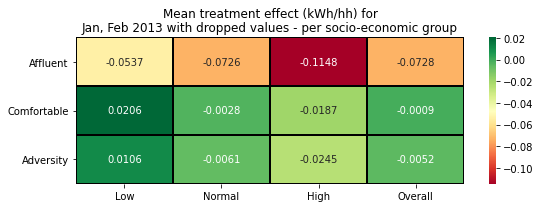

In [224]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(ME_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean treatment effect (kWh/hh) for'
             '\n'
             r'Jan, Feb 2013 with dropped values - per socio-economic group')
plt.tight_layout()
plt.savefig('../figs/ME_dropped_consumption_socio_jf.png')

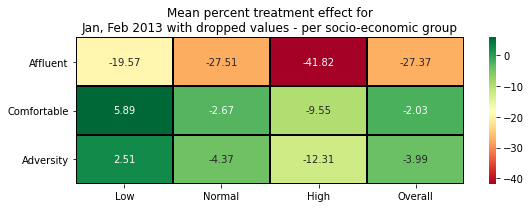

In [225]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.2f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)
ax.set_title(r'Mean percent treatment effect for'
             '\n'
             r'Jan, Feb 2013 with dropped values - per socio-economic group')
plt.tight_layout()
plt.savefig('../figs/MPE_dropped_consumption_socio_jf.png')

In [147]:
a1_dropped_af, b1_dropped_af, a2_dropped_af, b2_dropped_af = get_matrices_dropped(slice_2013_t_af, 
                                                                                  slice_2013_c_af, 
                                                                                  slice_2014_t_af, 
                                                                                  slice_2014_c_af,
                                                                                  0)

before anything (2784, 1685) (2784, 485) (2784, 1518) (2784, 457)
after cleaning (2784, 1223) (2784, 349) (2784, 993) (2784, 307)
after house intersection (2784, 748) (2784, 227) (2784, 748) (2784, 227)


In [93]:
b1_dropped_af_est = find_counterfactual(a2_dropped_af, b2_dropped_af, a1_dropped_af, b1_dropped_af)

In [53]:
a1_dropped_com, b1_dropped_com, a2_dropped_com, b2_dropped_com = get_matrices_dropped(slice_2013_t_com, 
                                                                                      slice_2013_c_com, 
                                                                                      slice_2014_t_com, 
                                                                                      slice_2014_c_com,
                                                                                      0)

before anything (2784, 1174) (2784, 320) (2784, 1111) (2784, 297)
after cleaning (2784, 898) (2784, 245) (2784, 710) (2784, 192)
after house intersection (2784, 545) (2784, 153) (2784, 545) (2784, 153)


In [94]:
b1_dropped_com_est = find_counterfactual(a2_dropped_com, b2_dropped_com, a1_dropped_com, b1_dropped_com)

In [55]:
a1_dropped_ad, b1_dropped_ad, a2_dropped_ad, b2_dropped_ad = get_matrices_dropped(slice_2013_t_ad, 
                                                                                  slice_2013_c_ad, 
                                                                                  slice_2014_t_ad, 
                                                                                  slice_2014_c_ad,
                                                                                  0)

before anything (2784, 1509) (2784, 296) (2784, 1399) (2784, 280)
after cleaning (2784, 1170) (2784, 237) (2784, 872) (2784, 173)
after house intersection (2784, 689) (2784, 138) (2784, 689) (2784, 138)


In [95]:
b1_dropped_ad_est = find_counterfactual(a2_dropped_ad, b2_dropped_ad, a1_dropped_ad, b1_dropped_ad)

In [102]:
a1_imputed_af, b1_imputed_af, a2_imputed_af, b2_imputed_af = get_matrices_imputed(slice_2013_t_af, 
                                                                                  slice_2013_c_af, 
                                                                                  slice_2014_t_af, 
                                                                                  slice_2014_c_af)

before anything (2784, 1685) (2784, 485) (2784, 1518) (2784, 457)
after imputation (2784, 1685) (2784, 485) (2784, 1518) (2784, 457)
after house intersection (2784, 1516) (2784, 454) (2784, 1516) (2784, 454)


In [103]:
b1_imputed_af_est = find_counterfactual(a2_imputed_af, b2_imputed_af, a1_imputed_af, b1_imputed_af)

In [104]:
a1_imputed_com, b1_imputed_com, a2_imputed_com, b2_imputed_com = get_matrices_imputed(slice_2013_t_com, 
                                                                                      slice_2013_c_com, 
                                                                                      slice_2014_t_com, 
                                                                                      slice_2014_c_com)

before anything (2784, 1174) (2784, 320) (2784, 1111) (2784, 297)
after imputation (2784, 1174) (2784, 320) (2784, 1111) (2784, 297)
after house intersection (2784, 1111) (2784, 297) (2784, 1111) (2784, 297)


In [105]:
b1_imputed_com_est = find_counterfactual(a2_imputed_com, b2_imputed_com, a1_imputed_com, b1_imputed_com)

In [106]:
a1_imputed_ad, b1_imputed_ad, a2_imputed_ad, b2_imputed_ad = get_matrices_imputed(slice_2013_t_ad, 
                                                                                  slice_2013_c_ad, 
                                                                                  slice_2014_t_ad, 
                                                                                  slice_2014_c_ad)

before anything (2784, 1509) (2784, 296) (2784, 1399) (2784, 280)
after imputation (2784, 1509) (2784, 296) (2784, 1399) (2784, 280)
after house intersection (2784, 1397) (2784, 278) (2784, 1397) (2784, 278)


In [107]:
b1_imputed_ad_est = find_counterfactual(a2_imputed_ad, b2_imputed_ad, a1_imputed_ad, b1_imputed_ad)

In [221]:
ME_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])

In [222]:
# b2 = b1_imputed_af
# b2_est = b1_imputed_af_est
b2 = b1_dropped_af
b2_est = b1_dropped_af_est

ME_consumption.loc['Affluent', 'Low'], MPE_consumption.loc['Affluent', 'Low'] = get_subset(b2, b2_est, lows, affluent)

ME_consumption.loc['Affluent', 'Normal'], MPE_consumption.loc['Affluent', 'Normal'] = get_subset(b2, b2_est, normals, affluent)

ME_consumption.loc['Affluent', 'High'], MPE_consumption.loc['Affluent', 'High'] = get_subset(b2, b2_est, highs, affluent)

ME_consumption.loc['Affluent', 'Overall'], MPE_consumption.loc['Affluent', 'Overall'] = get_subset(b2, b2_est, b2.index, affluent)



# b2 = b1_imputed_com
# b2_est = b1_imputed_com_est
b2 = b1_dropped_com
b2_est = b1_dropped_com_est

ME_consumption.loc['Comfortable', 'Low'], MPE_consumption.loc['Comfortable', 'Low'] = get_subset(b2, b2_est, lows, comfortable)

ME_consumption.loc['Comfortable', 'Normal'], MPE_consumption.loc['Comfortable', 'Normal'] = get_subset(b2, b2_est, normals, comfortable)

ME_consumption.loc['Comfortable', 'High'], MPE_consumption.loc['Comfortable', 'High'] = get_subset(b2, b2_est, highs, comfortable)

ME_consumption.loc['Comfortable', 'Overall'], MPE_consumption.loc['Comfortable', 'Overall'] = get_subset(b2, b2_est, b2.index, comfortable)



# b2 = b1_imputed_ad
# b2_est = b1_imputed_ad_est
b2 = b1_dropped_ad
b2_est = b1_dropped_ad_est

ME_consumption.loc['Adversity', 'Low'], MPE_consumption.loc['Adversity', 'Low'] = get_subset(b2, b2_est, lows, adversity)

ME_consumption.loc['Adversity', 'Normal'], MPE_consumption.loc['Adversity', 'Normal'] = get_subset(b2, b2_est, normals, adversity)

ME_consumption.loc['Adversity', 'High'], MPE_consumption.loc['Adversity', 'High'] = get_subset(b2, b2_est, highs, adversity)

ME_consumption.loc['Adversity', 'Overall'], MPE_consumption.loc['Adversity', 'Overall'] = get_subset(b2, b2_est, b2.index, adversity)

In [223]:
ME_consumption = ME_consumption.astype(float)
MPE_consumption = MPE_consumption.astype(float)

<AxesSubplot:>

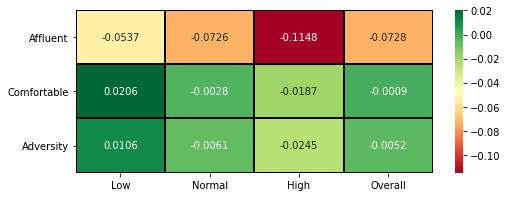

In [160]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(ME_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)

<AxesSubplot:>

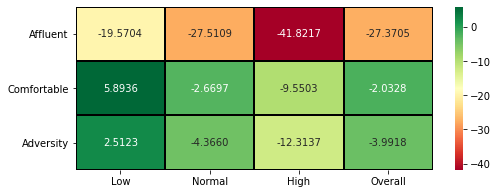

In [161]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(MPE_consumption, annot=True, fmt='.4f', linewidths=1, linecolor='black', cmap='RdYlGn', ax=ax)

In [135]:
delta = (b_2013 - b_2013_tilde) / b_2013_tilde

In [139]:
delta = (b_2013.mean(axis=1)-b_2013_tilde.mean(axis=1)) / b_2013_tilde.mean(axis=1)*100

In [142]:
delta = (b_2013_tilde.mean(axis=1)-b_2013.mean(axis=1)) / b_2013.mean(axis=1)*100

In [137]:
delta.flatten()

array([ 0.06723459, -0.93525902, -0.87861789, ..., -0.84944986,
       -0.66127186, -0.98075503])

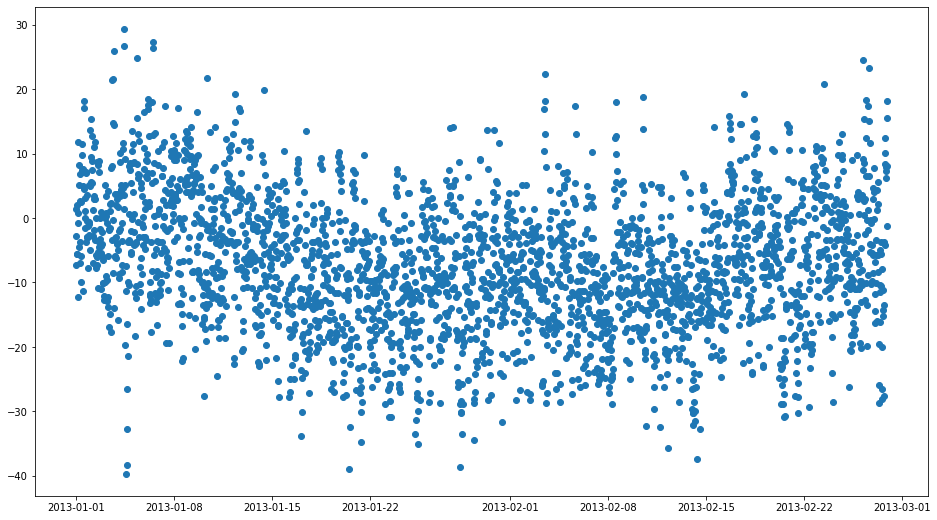

In [143]:
plt.figure(figsize=(16, 9))
plt.scatter(b_2013_.index, delta);

In [209]:
total_usage_2014['hour'] = total_usage_2014['date_time'].dt.hour

In [263]:
# time_of_day_2014 = total_usage_2014.groupby([total_usage_2014['hour'], total_usage_2014['treated']])['KWH/hh'].mean()
time_of_day_2014 = total_usage_2014.groupby([total_usage_2014['hour']])['KWH/hh'].mean()

In [376]:
len(a_2014_.mean(axis=1).values)

2784

In [471]:
def func(x, a, b, c, d, e, f):
    return [a * math.sin(e * x_i+ f) + b * math.sin(c * x_i) + d for x_i in x]

In [3]:
xdata = np.arange(0, 500)
ydata = a_2014_.mean(axis=1).values[:500]*10
yguess = func(xdata, 1.5, 0.2, 20, 2.5, 0.5, 10)

NameError: name 'a_2014_' is not defined

In [4]:
plt.subplots(figsize=(20, 10))
plt.plot(xdata, ydata, label='actual data')
plt.plot(xdata, yguess, 'r', label='guess data')
# plt.plot(xdata, func(xdata, *popt), 'r')
# , label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt)
plt.title('Consumption vs Temperature Fit')
plt.xlabel('time')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [303]:
from scipy.optimize import curve_fit

In [497]:
popt, _ = curve_fit(func, xdata, ydata, p0=(1.5, 0.2, 20, 2.5, 0.5, 10), bounds=[(0.01, 1, 0.08, -math.inf, -math.inf, -math.inf), (0.9, math.inf, 2, math.inf, math.inf, math.inf)])
popt

ValueError: `x0` is infeasible.

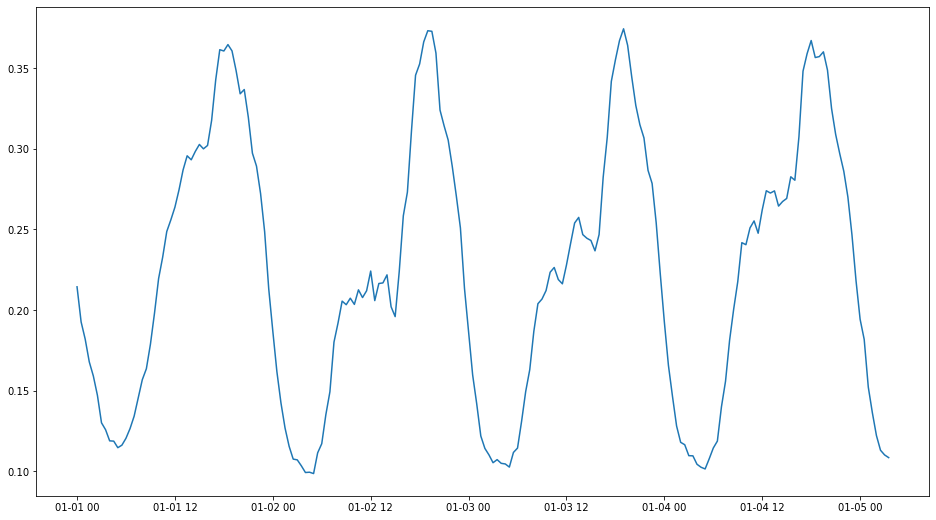

In [479]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
# plt.plot(b_2013_tilde.mean(axis=1)[:500])
# plt.plot(b_2013.mean(axis=1)[:500])
plt.plot(b_2014_.mean(axis=1)[:200]);

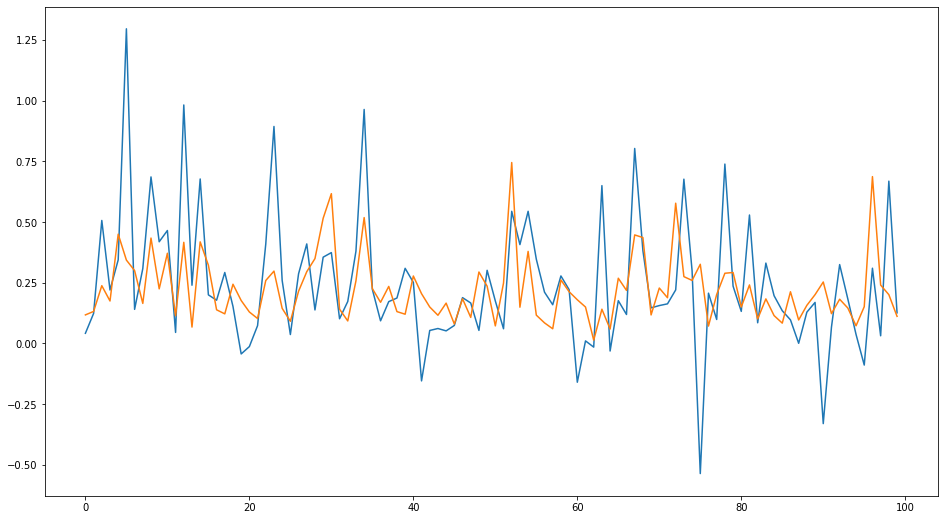

In [117]:
plt.figure(figsize=(16, 9))
plt.plot(b_2013_tilde.mean(axis=0)[:100])
plt.plot(b_2013.mean(axis=0)[:100])

In [498]:
def get_subset(mat, time, socio):
    return mat.loc[mat.index.isin(time), mat.columns.isin(socio)]

In [196]:
highs_affluent_delta = get_subset(highs, affluent)
lows_affluent_delta = get_subset(lows, affluent)

highs_comfortable_delta = get_subset(highs, comfortable)
lows_comfortable_delta = get_subset(lows, comfortable)

highs_adversity_delta = get_subset(highs, adversity)
lows_adversity_delta = get_subset(lows, adversity)

In [488]:
highs_affluent_delta.values.flatten()

array([ -177.80796468, -1480.07059122,   -26.44881328, ...,
         -69.70965394,  -161.20892852,   -32.27495502])

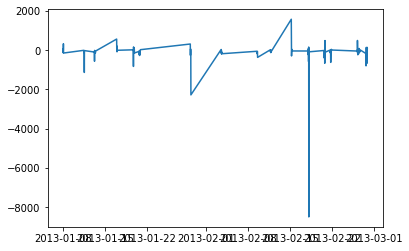

In [495]:
b_2013_.loc[b_2013_.index.isin(time), b_2013_.columns.isin(socio)]

In [494]:
highs_affluent_delta

house_id,MAC000005,MAC000015,MAC000017,MAC000048,MAC000052,MAC000064,MAC000075,MAC000076,MAC000082,MAC000109,...,MAC005395,MAC005413,MAC005445,MAC005470,MAC005488,MAC005489,MAC005507,MAC005515,MAC005541,MAC005550
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-07 23:00:00,-177.807965,-1480.070591,-26.448813,-50.730832,-88.909737,-15.171902,-91.478697,-59.859634,-34.611735,83.445620,...,-42.101885,-39.380842,-192.539691,-47.510116,-21.955720,-167.810130,-32.103580,-75.093634,-17.485480,157.790213
2013-01-07 23:30:00,-866.563579,-13.861489,-88.598932,-42.226237,-86.548868,-51.156269,-76.267886,-50.919357,-80.667301,1255.026796,...,-79.880578,-13.457720,-99.695761,-82.861390,-75.623528,-119.027457,-62.921304,-68.139307,-185.851712,202.142140
2013-01-08 00:00:00,174.993362,39.970815,-126.531975,-63.103772,-73.526206,-67.405472,-62.303098,-32.879907,-70.848230,-34.823217,...,-83.505768,-32.102836,-94.826344,-212.831650,-87.935337,-119.374389,-131.816106,-71.504275,-60.642835,-0.162613
2013-01-08 00:30:00,-69.962676,-68.880481,-128.747640,-27.841591,-127.873355,-44.220366,-76.844180,-72.424507,142.857173,216.975435,...,-83.526397,64.216745,-100.000000,-234.211913,-93.307221,-124.520317,-23.614551,-71.566181,-49.882633,2676.624622
2013-01-08 01:00:00,-47.853749,-83.378901,-124.312138,-275.799169,-90.023528,-60.251722,-752.428974,-70.387794,-86.521612,-76.141121,...,-92.756195,1251.565489,-93.423439,-134.290336,-76.398894,0.921061,-974.885242,-78.670934,11.596766,-49.599358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-27 20:30:00,-64.007950,-86.151390,-88.038683,-81.599630,-87.946223,-161.121133,-41.868058,78.295532,-124.669837,-91.035243,...,139.908371,-62.353362,-83.813236,-125.948925,-74.962686,-13.140825,-117.470837,-1311.852422,-126.448361,-70.812435
2013-02-27 21:00:00,-75.586254,-77.622614,-90.013730,-83.335146,-86.701291,-121.333252,68.846754,-64.806647,-104.961662,-92.213425,...,210.639765,-50.516862,-96.102278,-116.013236,-70.898386,-58.396919,-161.000207,-146.239928,-149.503754,-67.191484
2013-02-27 21:30:00,-115.899408,13.922277,-70.377686,-55.666020,-93.765717,-76.075589,-84.282327,18.225894,-106.125051,-84.551946,...,-2858.592460,-79.596598,-81.894343,-140.445223,-68.967376,-64.159444,-507.795277,-150.430415,-181.086076,-44.601139
